In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib tk

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import Basis
import sys
from tqdm import tnrange

# Setup

In [3]:
CONST_EPS = 1E-9  # Epsilon value to use for the numerical epsilon

# The properties along the xi direction.
CONST_P = 6  # The order of the patch along the direction
CONST_NUM_CONTROL_PTS_XI = 11  # Number of control points in the direction (make it an odd number)

# Properties of the patch in the eta direction
CONST_Q = 1  # The order of the patch along the direction
CONST_NUM_CONTROL_PTS_ETA = 2  # Number of control points in the direction

# Domain Parameters (The physical domain parameters, before deformation to add the bump)
CONST_X_MIN = 0.0
CONST_X_MAX = 5.0

CONST_Y_MIN = 0.0
CONST_Y_MAX = 2.0

# How much to lift middle points by to add the bump
CONST_DELTA_Y = 0.5


In [4]:

# Name for the output file
CONST_Output_file_name = "geometry_parameters_internal_channel_NURBS_P%d_Q%d_NXi%d_NEta%d.geo"%(CONST_P, 
                                        CONST_Q, CONST_NUM_CONTROL_PTS_XI, CONST_NUM_CONTROL_PTS_ETA)

# Bump Functions

In [5]:

def get_knot_vectors(p, n):
    
    """
    Get the knot vector given the order and the number of points in
    the given direction. Is a vector in the domain ([-1, 1]).
    
    :param p: The order
    :param n: The number of points
    """
    
    # Spline parameters
    m = n + p + 1  # number of elements in knot vector

    # Create a uniform open knot vector (use an open knot vector so first and last
    # knot are repeated p+1 times). Also, domain of the knot vector is [-1,1]
    knots = []

    for i in range(p+1):
        knots.append(-1.)

    num_non_end_knots = m - 2*(p+1)
    delta_knot = 2./(num_non_end_knots+1)

    for i in range(1, num_non_end_knots+1):
        knots.append(-1. + i*delta_knot)

    for i in range(p+1):
        knots.append(1.)
        
    return knots


In [6]:

def get_optimization_pts(ControlPoints_and_Weights):

    """
    Go through the Control Point net and set the points that will 
    act as the optimization control points. This method will combine
    the points into a list and also specify each point's degrees of 
    freedom. 

    :param ControlPoints_and_Weights: The net (matrix) of control points and
        weights.

    :return : A list with the control points for the optimization. The list
        will hold tuples of the form (cntrl_pt, dof_x_bool, dof_y_bool)
        where dof_x_bool = 0 if the x direction cannot be used as a degree of 
        freedom and is 1 if it can be (same for dof_y_bool)
    """

    # For the bump case, fix the corner points and allow the middle points to move around
    optimization_control_pt_list = []

    # Subtract 2 since corner points cannot move
    num_pts_xi = len(ControlPoints_and_Weights)  # First dimension gives the number of points in the xi direction
    num_pts = num_pts_xi - 2 

    for i in range(1,num_pts+1):
        optimization_control_pt_list.append((ControlPoints_and_Weights[i][0], 0, 1))

    # Place the limits on each design variable
    # NOTE: For now, only y can be adjusted so set those limits.
    optimization_control_pt_limit_list = []

    y_max = CONST_Y_MAX
    y_min = CONST_Y_MIN

    for i in range(len(optimization_control_pt_list)):

        pt = optimization_control_pt_list[i][0]
        optimization_control_pt_limit_list.append((pt, y_min, y_max))

    return optimization_control_pt_list, optimization_control_pt_limit_list


def get_channel_patch_parameters(P, num_pts_xi, Q, num_pts_eta, delta_y_bottom, num_pts_mid=1):
    
    """
    Obtain the knot vectors and the control points for the channel.
    
    :param P: Order in the xi direction.
    :param num_pts_xi: The number of control points in the xi direction.
    :param Q: Order in the eta direction.
    :param num_pts_eta: The number of points in the eta direction.
    :param delta_y_bottom: How much to shift the control points (center ones) for
        the bottom of the grid up (to create the bump)
    :param num_pts_mid: The number of points around the middle one to also raise up.
    
    :return: Dictionary with the patch parameters
    """
    
    # Get the knot vectors for the xi and eta directions
    xiVector = get_knot_vectors(P, num_pts_xi)
    etaVector = get_knot_vectors(Q, num_pts_eta)
    
    # Create the grid of control points. For each one, also assign a weight. 
    # Initialize the grid with eqaually spaced points and set all the weights
    # to one.
    ControlPoints_and_Weights = []
    
    dx_control_pts = (CONST_X_MAX - CONST_X_MIN)/(num_pts_xi-1)
    dy_control_pts = (CONST_Y_MAX - CONST_Y_MIN)/(num_pts_eta-1)
    
    for i in range(num_pts_xi):
        col = []
        for j in range(num_pts_eta):
            
            x_ij = CONST_X_MIN + i*dx_control_pts
            y_ij = CONST_Y_MIN + j*dy_control_pts
            
            col.append([x_ij, y_ij, 1.0])
            
        ControlPoints_and_Weights.append(col)
    
    
    # Shift the correct control points at the bottom up by the specified
    # amount to create the bump
    
    i_mid_index = int((num_pts_xi-1)/2.0)
    ControlPoints_and_Weights[i_mid_index][0][1] += delta_y_bottom
    
    for i in range(1, num_pts_mid):
        ControlPoints_and_Weights[i_mid_index+i][0][1] += delta_y_bottom
        ControlPoints_and_Weights[i_mid_index-i][0][1] += delta_y_bottom
    
    # =========================================================================
    # NOTE: This section can be used to set some of the weights for the points
    # to not be 1. This way we can test the NURBS implementation.
    
    # Arbitraryily set the values to 1/sqrt(2)

    ControlPoints_and_Weights[i_mid_index][0][2] = 1./math.sqrt(2)
    
    for i in range(1, num_pts_mid):
        ControlPoints_and_Weights[i_mid_index+i][0][2] = 1./math.sqrt(2)
        ControlPoints_and_Weights[i_mid_index-i][0][2] = 1./math.sqrt(2)
    
    # =========================================================================
    
    
    # Get the list of optimization control points (if we want to use this case for
    # optimization purposes)
    optimization_control_pt_list, optimization_control_pt_limit_list = get_optimization_pts(ControlPoints_and_Weights)
    
    
    patch_parameters = {
        "xiVector" : xiVector,
        "etaVector" : etaVector,
        "ControlPoints_and_Weights" : ControlPoints_and_Weights,
        "P" : P,
        "Q" : Q,
        "Optimization_ControlPoints_and_Weights" : optimization_control_pt_list,
        "Optimization_ControlPoints_Limits" : optimization_control_pt_limit_list,
    }

    return patch_parameters


In [7]:

def NURBS_patch(xi,eta,BasisFunctionsList, ControlPoints_and_Weights, grad_index=None):

    """
    Knowing the basis functions and locations of the points,
    compute the parametric NURBS patch expression.
    
    NOTE: This function is used for plotting.

    :param xi: The xi value to evaluate the patch at
    :param eta: The eta value to evaluate the patch at
    :param BasisFunctionsList: The list (list of lists in 2D) of basis functions
    :param ControlPoints_and_Weights: The list (list of lists in 2D) of Points. 
        The i,j index of the Point structure points to a list of the form [x,y,weight], 
        which correspond to the physical location and weight of a given control point
    :param grad_index: An index value of 0 or 1 if the basis functions list provided 
        contains a matrix of lists holding the gradients of the basis functions

    :return: Value of the patch on the physical domain at the given xi,eta point on the 
        parametric domain. Using this function in a lambda expression will 
        ease the plotting process. The return list has two dimensions [x, y]. If the 
        gradients are provided, then the return list is [del_x, del_y], where del is the partial
        with respect to whichever parameter (xi or eta) is specified by grad_index
    """

    physical_val = [0,0]

    numI = len(BasisFunctionsList)
    numJ = len(BasisFunctionsList[0])

    for i in range(numI):
        for j in range(numJ):
            for k in range(2):

                if grad_index is not None:
                    physical_val[k] = physical_val[k] + BasisFunctionsList[i][j][grad_index](xi,eta) * ControlPoints_and_Weights[i][j][k]

                else:
                    physical_val[k] = physical_val[k] + BasisFunctionsList[i][j](xi,eta) * ControlPoints_and_Weights[i][j][k]

    return physical_val


# Patch Generation

In [8]:

patch_parameters = get_channel_patch_parameters(CONST_P, CONST_NUM_CONTROL_PTS_XI, CONST_Q, CONST_NUM_CONTROL_PTS_ETA,
                                               CONST_DELTA_Y, num_pts_mid=2)


In [9]:

# Output the patch parameters to stdout

for k in patch_parameters.keys():
    print("- %s : %s \n" % (k, patch_parameters[k]))


- xiVector : [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.6, -0.19999999999999996, 0.20000000000000018, 0.6000000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

- etaVector : [-1.0, -1.0, 1.0, 1.0] 

- ControlPoints_and_Weights : [[[0.0, 0.0, 1.0], [0.0, 2.0, 1.0]], [[0.5, 0.0, 1.0], [0.5, 2.0, 1.0]], [[1.0, 0.0, 1.0], [1.0, 2.0, 1.0]], [[1.5, 0.0, 1.0], [1.5, 2.0, 1.0]], [[2.0, 0.5, 0.7071067811865475], [2.0, 2.0, 1.0]], [[2.5, 0.5, 0.7071067811865475], [2.5, 2.0, 1.0]], [[3.0, 0.5, 0.7071067811865475], [3.0, 2.0, 1.0]], [[3.5, 0.0, 1.0], [3.5, 2.0, 1.0]], [[4.0, 0.0, 1.0], [4.0, 2.0, 1.0]], [[4.5, 0.0, 1.0], [4.5, 2.0, 1.0]], [[5.0, 0.0, 1.0], [5.0, 2.0, 1.0]]] 

- P : 6 

- Q : 1 

- Optimization_ControlPoints_and_Weights : [([0.5, 0.0, 1.0], 0, 1), ([1.0, 0.0, 1.0], 0, 1), ([1.5, 0.0, 1.0], 0, 1), ([2.0, 0.5, 0.7071067811865475], 0, 1), ([2.5, 0.5, 0.7071067811865475], 0, 1), ([3.0, 0.5, 0.7071067811865475], 0, 1), ([3.5, 0.0, 1.0], 0, 1), ([4.0, 0.0, 1.0], 0, 1), ([4.5, 0.0, 1.0]

## Visualize Patch
Plot the patch (along with the control points) to see what it looks like

In [16]:
def plot_patch(patch_parameters):

    """
    Plot the given patch using matplotlib. Display the control points as well
    as the constant knot lines. For the xi and eta
    values on the edge (boundary), subtract or add a small epsilon value to ensure
    they are in the patch domain.

    :param patch_parameters: The dictionary with the patch_parameters
    """

    xiVector = patch_parameters["xiVector"]
    etaVector = patch_parameters["etaVector"]
    ControlPoints_and_Weights = patch_parameters["ControlPoints_and_Weights"]
    P = patch_parameters["P"]
    Q = patch_parameters["Q"]

    # Get the NURBS basis functions associated with each control point
    NURBS_basis_functions = Basis.get_NURBS_basis_functions(ControlPoints_and_Weights, P, Q, xiVector, etaVector)

    # Get the patch parametric function
    NURBS_patch_function = lambda xi,eta,BasisFunctionsList=NURBS_basis_functions, \
            ControlPoints_and_Weights=ControlPoints_and_Weights: \
            NURBS_patch(xi,eta, BasisFunctionsList, ControlPoints_and_Weights)

    # The distinct knot values along both parametric coordinates (xi and eta)
    xi_distinct_values = []
    eta_distinct_values = []

    xi_distinct_values.append(xiVector[0])
    xi_distinct_values.append(xiVector[-1])
    
    eta_distinct_values.append(etaVector[0])
    eta_distinct_values.append(etaVector[-1])
    
    
#     for xi_val in xiVector:
        
#         if xi_val not in xi_distinct_values:
#             xi_distinct_values.append(xi_val)

#     for eta_val in etaVector:
        
#         if eta_val not in eta_distinct_values:
#             eta_distinct_values.append(eta_val)


    # Discretize the xi and eta domains so we can plot the lines
    num_linspace_pts = 40
    eta_linspace = np.linspace(etaVector[0]+CONST_EPS, etaVector[-1]-CONST_EPS, num_linspace_pts)
    xi_linspace = np.linspace(xiVector[0]+CONST_EPS, xiVector[-1]-CONST_EPS, num_linspace_pts)

    # Plot the constant xi values:
    for xi_val_i in tnrange(len(xi_distinct_values)):
        xi_val = xi_distinct_values[xi_val_i]
        if xi_distinct_values.index(xi_val) == 0:
            xi_val += CONST_EPS
        elif xi_distinct_values.index(xi_val) == (len(xi_distinct_values)-1):
            xi_val -= CONST_EPS

        xPlotPts = []
        yPlotPts = []

        for eta_val in eta_linspace:
            xy_pt = NURBS_patch_function(xi_val, eta_val)
            xPlotPts.append(xy_pt[0])
            yPlotPts.append(xy_pt[1])

        plt.plot(xPlotPts, yPlotPts, c='b')

    # Plot the constant eta values
    for eta_val_i in tnrange(len(eta_distinct_values)):
        eta_val = eta_distinct_values[eta_val_i]
        
        if eta_distinct_values.index(eta_val) == 0:
            eta_val += CONST_EPS
        elif eta_distinct_values.index(eta_val) == (len(eta_distinct_values)-1):
            eta_val -= CONST_EPS

        xPlotPts = []
        yPlotPts = []

        for xi_val in xi_linspace:
            xy_pt = NURBS_patch_function(xi_val, eta_val)
            xPlotPts.append(xy_pt[0])
            yPlotPts.append(xy_pt[1])

        plt.plot(xPlotPts, yPlotPts, c='b')

    # Scatter the control points
    xPlotPts = []
    yPlotPts = []
    for i in range(len(ControlPoints_and_Weights)):
        for j in range(len(ControlPoints_and_Weights[0])):
            xPlotPts.append(ControlPoints_and_Weights[i][j][0])
            yPlotPts.append(ControlPoints_and_Weights[i][j][1])

    plt.scatter(xPlotPts, yPlotPts, c='r')

    plt.grid()
    

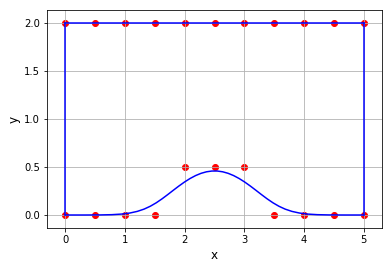

In [17]:
plot_patch(patch_parameters)

plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)

plt.savefig("internal_channel_patch.pdf")


# Output File
Output the patch file so it can be input into the DPG Code

In [15]:
def output_file(patch_parameters):

    """
    Output the file with the patch parameters. The DPG code will
    read this file and use the values to perform the parametric
    mapping

    NOTE: Optimization_ControlPoints_and_Weights is a key that, when present, 
        corresponds to the control points used for the optimization. If this 
        data is present, then print it as well in the .geo file

    :param patch_parameters: The parameters used to define the patch
    """

    xiVector = patch_parameters["xiVector"]
    etaVector = patch_parameters["etaVector"]
    ControlPoints_and_Weights = patch_parameters["ControlPoints_and_Weights"]
    P = patch_parameters["P"]
    Q = patch_parameters["Q"]

    num_xi_pts = len(ControlPoints_and_Weights)
    num_eta_pts = len(ControlPoints_and_Weights[0])

    # Load all the control points into a list (a connecitivity format will
    # be used to load the points)
    ControlPoints_and_Weights_list = []
    for i in range(num_xi_pts):
        for j in range(num_eta_pts):
            if ControlPoints_and_Weights[i][j] not in ControlPoints_and_Weights_list:
                ControlPoints_and_Weights_list.append(ControlPoints_and_Weights[i][j])

    with open(CONST_Output_file_name, "w") as fp:

        fp.write("/** Geometry parameters for test case: euler/steady/NURBS\n")
        fp.write("*/\n\n")

        # The order of the patch in each parameter direction
        fp.write("P(xi_order) %d \n" % P)
        fp.write("Q(eta_order) %d \n" % Q)
        fp.write("\n")

        # The knot vectors
        fp.write("knots_xi %d \n" % len(xiVector))
        for val in xiVector:
            fp.write("%.14e \n" % val)
        fp.write("\n")
        fp.write("knots_eta %d \n" % len(etaVector))
        for val in etaVector:
            fp.write("%.14e \n" % val)
        fp.write("\n")
        fp.write("\n")

        # Control Point Data information
        fp.write("Control_Point_Data %d \n" % len(ControlPoints_and_Weights_list))
        for pt in ControlPoints_and_Weights_list:
            fp.write("%.14e %.14e %.14e \n" % (pt[0], pt[1], pt[2]))
        fp.write("\n")

        # Connectivity Information	
        fp.write("Control_Point_Connectivity %d %d\n" % (num_xi_pts, num_eta_pts))
        for i in range(num_xi_pts):
            for j in range(num_eta_pts):
                fp.write("%d " % ControlPoints_and_Weights_list.index(ControlPoints_and_Weights[i][j]))
            fp.write("\n")
        fp.write("\n")

        if "Optimization_ControlPoints_and_Weights" in patch_parameters:

            #Optimization Information
            optimization_data_tuples = patch_parameters['Optimization_ControlPoints_and_Weights']

            fp.write("Optimization_Point_Connectivity %d\n" % (len(optimization_data_tuples)))
            for data_tuple in optimization_data_tuples:
                fp.write("%d %d %d \n" % (ControlPoints_and_Weights_list.index(data_tuple[0]), data_tuple[1], data_tuple[2]))
            fp.write("\n")

            optimization_control_pt_limit_tuples = patch_parameters['Optimization_ControlPoints_Limits']
            fp.write("Optimization_Point_Limit %d\n" % (len(optimization_control_pt_limit_tuples)))
            for data_tuple in optimization_control_pt_limit_tuples:
                fp.write("%d %e %e \n" % (ControlPoints_and_Weights_list.index(data_tuple[0]), data_tuple[1], data_tuple[2]))
            fp.write("\n")
            

In [16]:
output_file(patch_parameters)